# NBA Regular Season 2019/2020 Ranking Prediction

This project's goal is to use Data Science techniques (statistics, probabilities, ml) to predict which team will have the highest probability of winning the trophy at the end of the season.

To do this, we will approach this problem as a classification problem (we will compute the probability of each team to be the winner).

The data related to each team statistics has been scraped on https://stats.nba.com from 1996 to 2019, the scripts to do the scraping are available in my GitHub repository here : https://github.com/cyriltso/nba_prediction.

For the moment, the dataset only contains the traditional statistics related to each team, but if more features is need in order to improve our models, we will go scrape and add them to the current dataset.

This notebook contains all the analysis, visualization and modeling process.

### 1. Import libraries

In [1]:
### Ignore warning messages

import warnings
warnings.filterwarnings("ignore")

### Data Manipulation & Visualization

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from math import *

### Machine Learning

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

### Graphics Settings

%pylab inline 
sns.set(style = 'whitegrid', palette = 'pastel', font_scale = 1.5)
rcParams['figure.figsize'] = 20, 10

Populating the interactive namespace from numpy and matplotlib


### 2. Importing data

The scraped data are stored in a CSV file, so we will use Pandas to load it as a DataFrame.

All the features defined in the DataFrame are explained on the NBA official website : https://stats.nba.com/help/glossary/.

In [62]:
### Loading the dataset

df = pd.read_csv('/Users/cyriltso/Documents/nba_prediction/data/team_stats.csv', sep=';')
df.head()

season                   team  title_win  regular_season_rank  \
0  2018/2019        Milwaukee Bucks          0                    1   
1  2018/2019        Toronto Raptors          1                    2   
2  2018/2019  Golden State Warriors          0                    3   
3  2018/2019         Denver Nuggets          0                    4   
4  2018/2019        Houston Rockets          0                    5   

   game_played  wins  losses  wins_ratio  minutes_played  scoring_average  \
0         82.0  60.0    22.0       0.732            48.2            118.1   
1         82.0  58.0    24.0       0.707            48.5            114.4   
2         82.0  57.0    25.0       0.695            48.3            117.7   
3         82.0  54.0    28.0       0.659            48.1            110.7   
4         82.0  53.0    29.0       0.646            48.4            113.9   

   ...  defensive_rebounds  total_rebounds  assists  turnovers  steals  \
0  ...                40.4            49.7     26.0       13.9     7.5   
1  ...                35.6            45.2     25.4       14.0     8.3   
2  ...                36.5            46.2     29.4       14.3     7.6   
3  ...                34.5            46.4     27.4       13.4     7.7   
4  ...                31.9            42.1     21.2       13.3     8.5   

   blocks  blocks_attempts  personal_fouls  personal_fouls_drawn  plus_minus  
0     5.9              4.8            19.6                  20.2         8.9  
1     5.3              4.5            21.0                  20.5         6.1  
2     6.4              3.6            21.4                  19.5         6.5  
3     4.4              5.0            20.0                  20.4         4.0  
4     4.9              4.5            22.0                  20.0         4.8  

[5 rows x 30 columns]

### 3. Exploratory Data Analysis

-  Data Overview
-  Numerical Features
-  Advanced Analysis

#### 3.1. Data Overview

In [6]:
### Dimension of the data

df.shape

(682, 30)

In [7]:
### Information related to the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 30 columns):
season                     682 non-null object
team                       682 non-null object
title_win                  682 non-null int64
regular_season_rank        682 non-null int64
game_played                682 non-null float64
wins                       682 non-null float64
losses                     682 non-null float64
wins_ratio                 682 non-null float64
minutes_played             682 non-null float64
scoring_average            682 non-null float64
field_goals_made           682 non-null float64
field_goals_attempts       682 non-null float64
field_goals_percentage     682 non-null float64
three_points_made          682 non-null float64
three_points_attempts      682 non-null float64
three_points_percentage    682 non-null float64
free_throws_made           682 non-null float64
free_throws_attempts       682 non-null float64
free_throws_percentage     682 non-nu

In [8]:
### Checking if the target variable is balanced or not

df['title_win'].value_counts()

0    659
1     23
Name: title_win, dtype: int64

The target value seems to be highly imbalanced so we can't use **accuracy** as an evaluation metric to judge our machine learning models performances.

>**Note** : The fact that the dataset is imbalanced is logical because there can only be one winner per season for 30 teams.

#### 3.2. Numerical Features

Analyzing all the numerical features in the dataset.

In [12]:
### Descriptive Statistics

to_drop_stats = [
    'regular_season_rank', 'game_played', 'wins',
    'losses', 'wins_ratio', 'minutes_played',
    'field_goals_made', 'field_goals_attempts', 'three_points_made',
    'three_points_attempts', 'free_throws_made', 'free_throws_attempts',
    'total_rebounds', 'blocks_attempts', 'title_win'
]

df_stats = df.drop(to_drop_stats, axis=1)

df_stats.describe()

scoring_average  field_goals_percentage  three_points_percentage  \
count       682.000000              682.000000               682.000000   
mean         98.929472               45.185484                35.352493   
std           5.946911                1.622260                 2.097646   
min          81.900000               40.100000                26.400000   
25%          94.900000               44.200000                34.100000   
50%          98.200000               45.100000                35.300000   
75%         102.500000               46.200000                36.700000   
max         118.100000               50.400000                42.800000   

       free_throws_percentage  offensive_rebounds  defensive_rebounds  \
count              682.000000          682.000000          682.000000   
mean                75.439736           11.400587           30.915103   
std                  2.996663            1.463406            2.125288   
min                 66.000000            7.600000           24.900000   
25%                 73.700000           10.400000           29.500000   
50%                 75.600000           11.400000           30.700000   
75%                 77.500000           12.400000           32.300000   
max                 82.900000           17.200000           40.400000   

          assists   turnovers      steals      blocks  personal_fouls  \
count  682.000000  682.000000  682.000000  682.000000      682.000000   
mean    21.835337   14.639296    7.697947    4.924194       21.264956   
std      2.009580    1.206983    0.912000    0.837459        1.773741   
min     15.600000   11.200000    5.500000    2.400000       16.600000   
25%     20.500000   13.900000    7.100000    4.300000       20.000000   
50%     21.600000   14.600000    7.600000    4.900000       21.200000   
75%     23.100000   15.300000    8.300000    5.500000       22.500000   
max     30.400000   19.000000   12.000000    8.200000       27.100000   

       personal_fouls_drawn  plus_minus  
count            682.000000  682.000000  
mean              12.885337    0.001320  
std                9.986079    4.583567  
min                0.000000  -13.900000  
25%                0.100000   -3.075000  
50%               19.400000    0.200000  
75%               20.900000    3.400000  
max               25.700000   11.600000

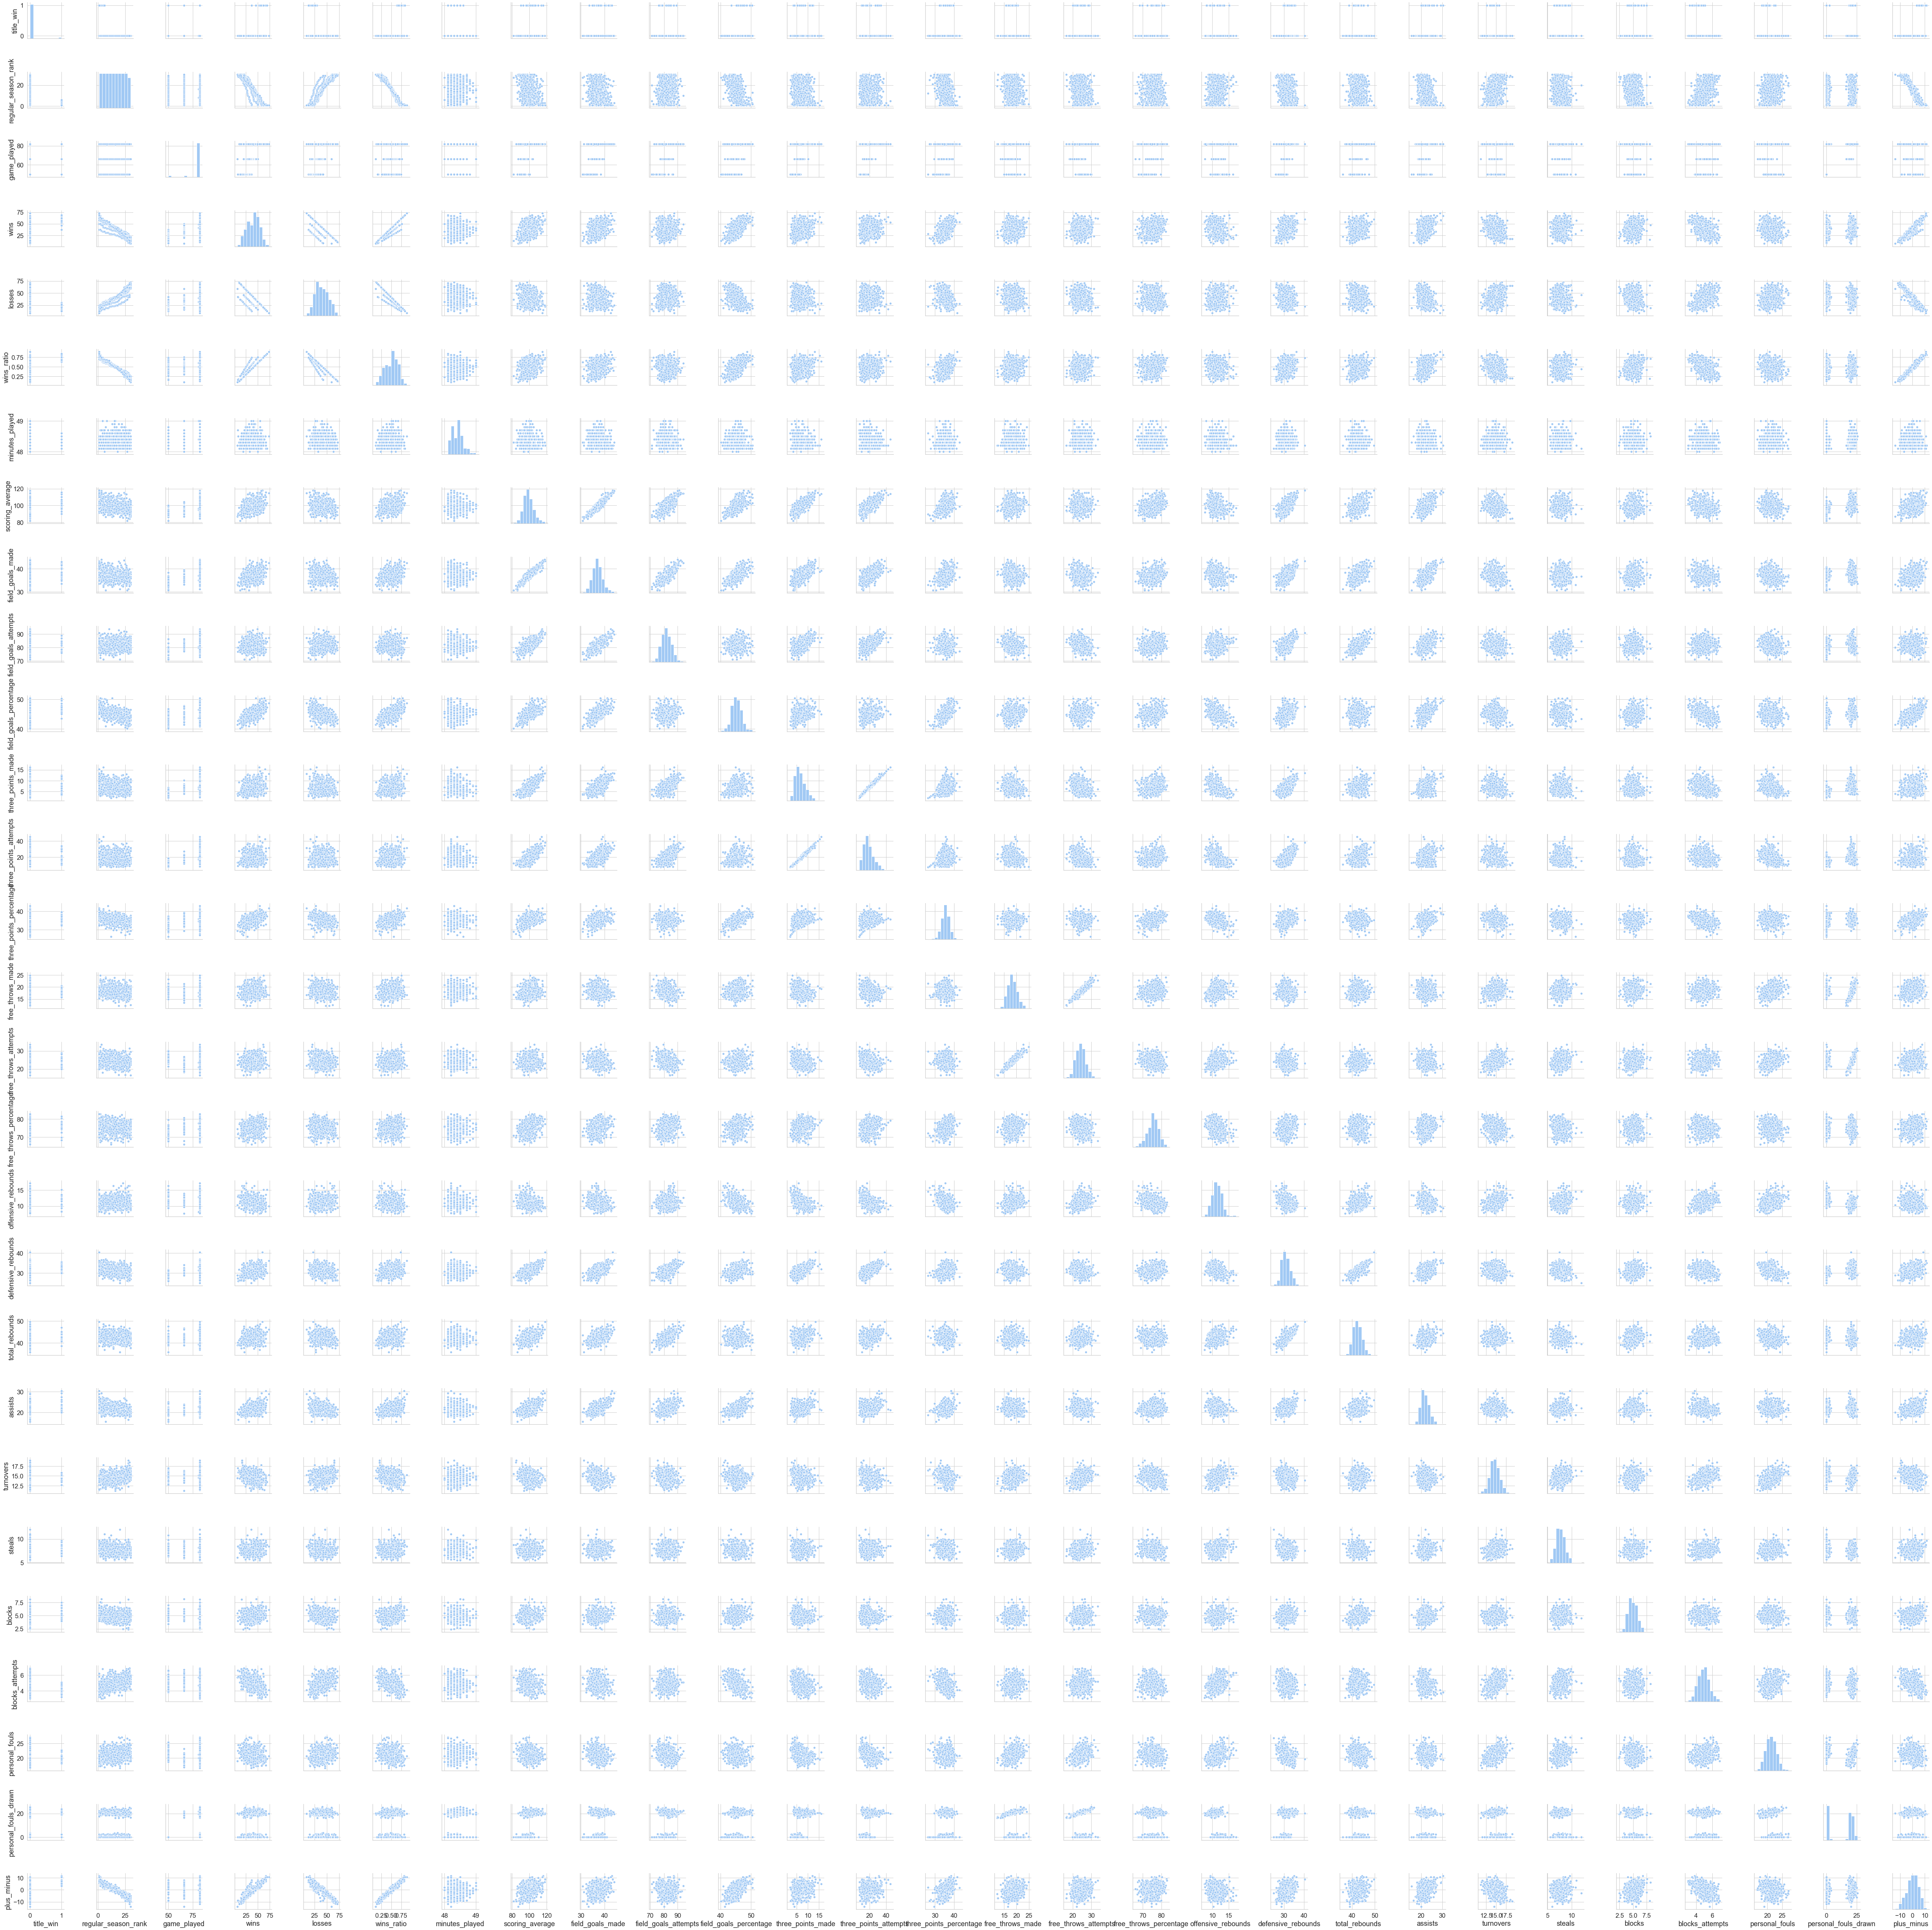

In [13]:
### Univariate and Bivariate analysis

sns.pairplot(df)

**Insights from the plot above :**

Most of the features seems to follow some sort of Gaussian Distribution which is good for the next steps of the study.

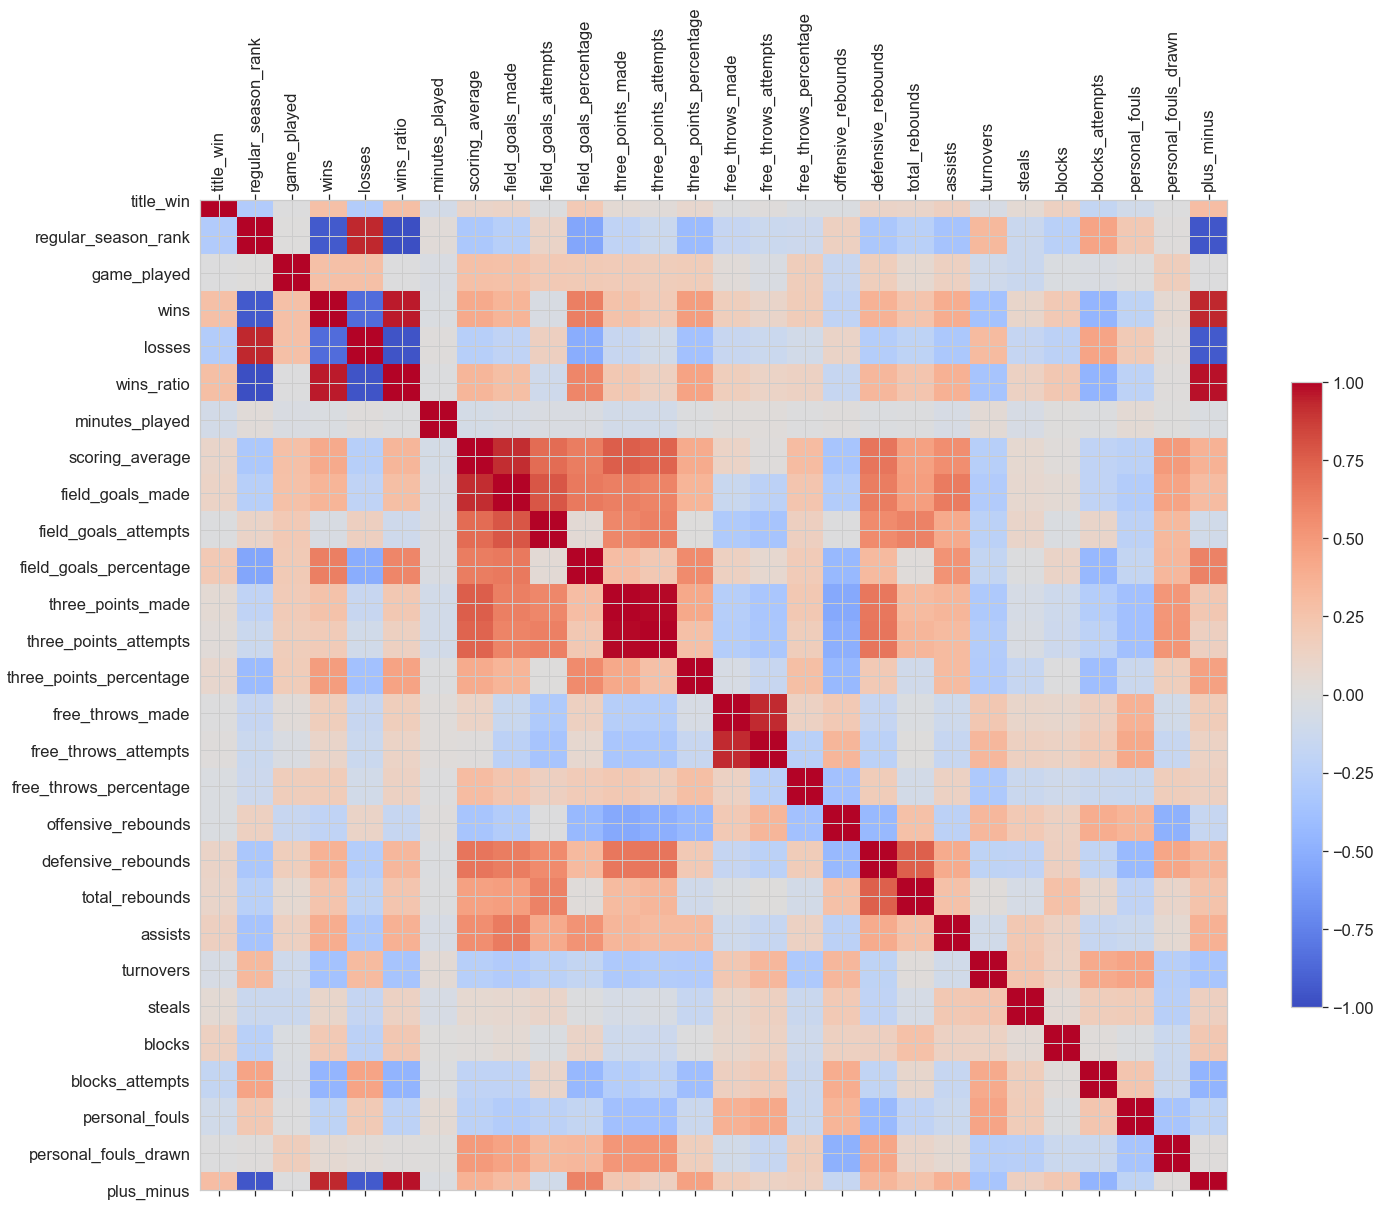

In [14]:
### Correlation between features

df_heatmap = df.drop(['team', 'season'], axis=1)
correlations = df_heatmap.corr()

fig = plt.figure(figsize = (23, 23))
ax = fig.add_subplot(111)
cmap = get_cmap('coolwarm')
cax = ax.matshow(correlations, cmap = cmap, vmin=-1, vmax=1)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
fig.colorbar(cax, shrink = 0.5)
ticks = np.arange(len(df_heatmap.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df_heatmap.columns)
ax.set_yticklabels(df_heatmap.columns)
plt.show()

**Insights from the plot above :**

A lot of features seem to be correlated, which is normal because a lot of metrics in Basketball are dependant between them (for example, a team with a good scoring average will be more likely to have a high regular season ranking compared to a team with a bad scoring average). So, we will have to remove some of them in order to reduce redundancy in our data so that we won't feed our models with noises.

><b>Key takeways</b> : 
-  Most of the features don't seem to be highly correlated with the title_win target feature. This can possibly mean that in order for a team to be able to win the trophy, he will need to be more or less good in every categories and also have a little bit of good fortune.
-  This plot also shows us that a team doesn't necessarly need to be first in the regular season ranking in order to be able to win the NBA title (as the correlation between title_win and regular_season_rank seems to be quite low).

#### 3.3. Advanced Analysis

In this sub-section, we will make some advanced analysis in order to answer to some questions.

Text(0.5, 1.0, 'Evolution of the NBA teams playstyle over years')

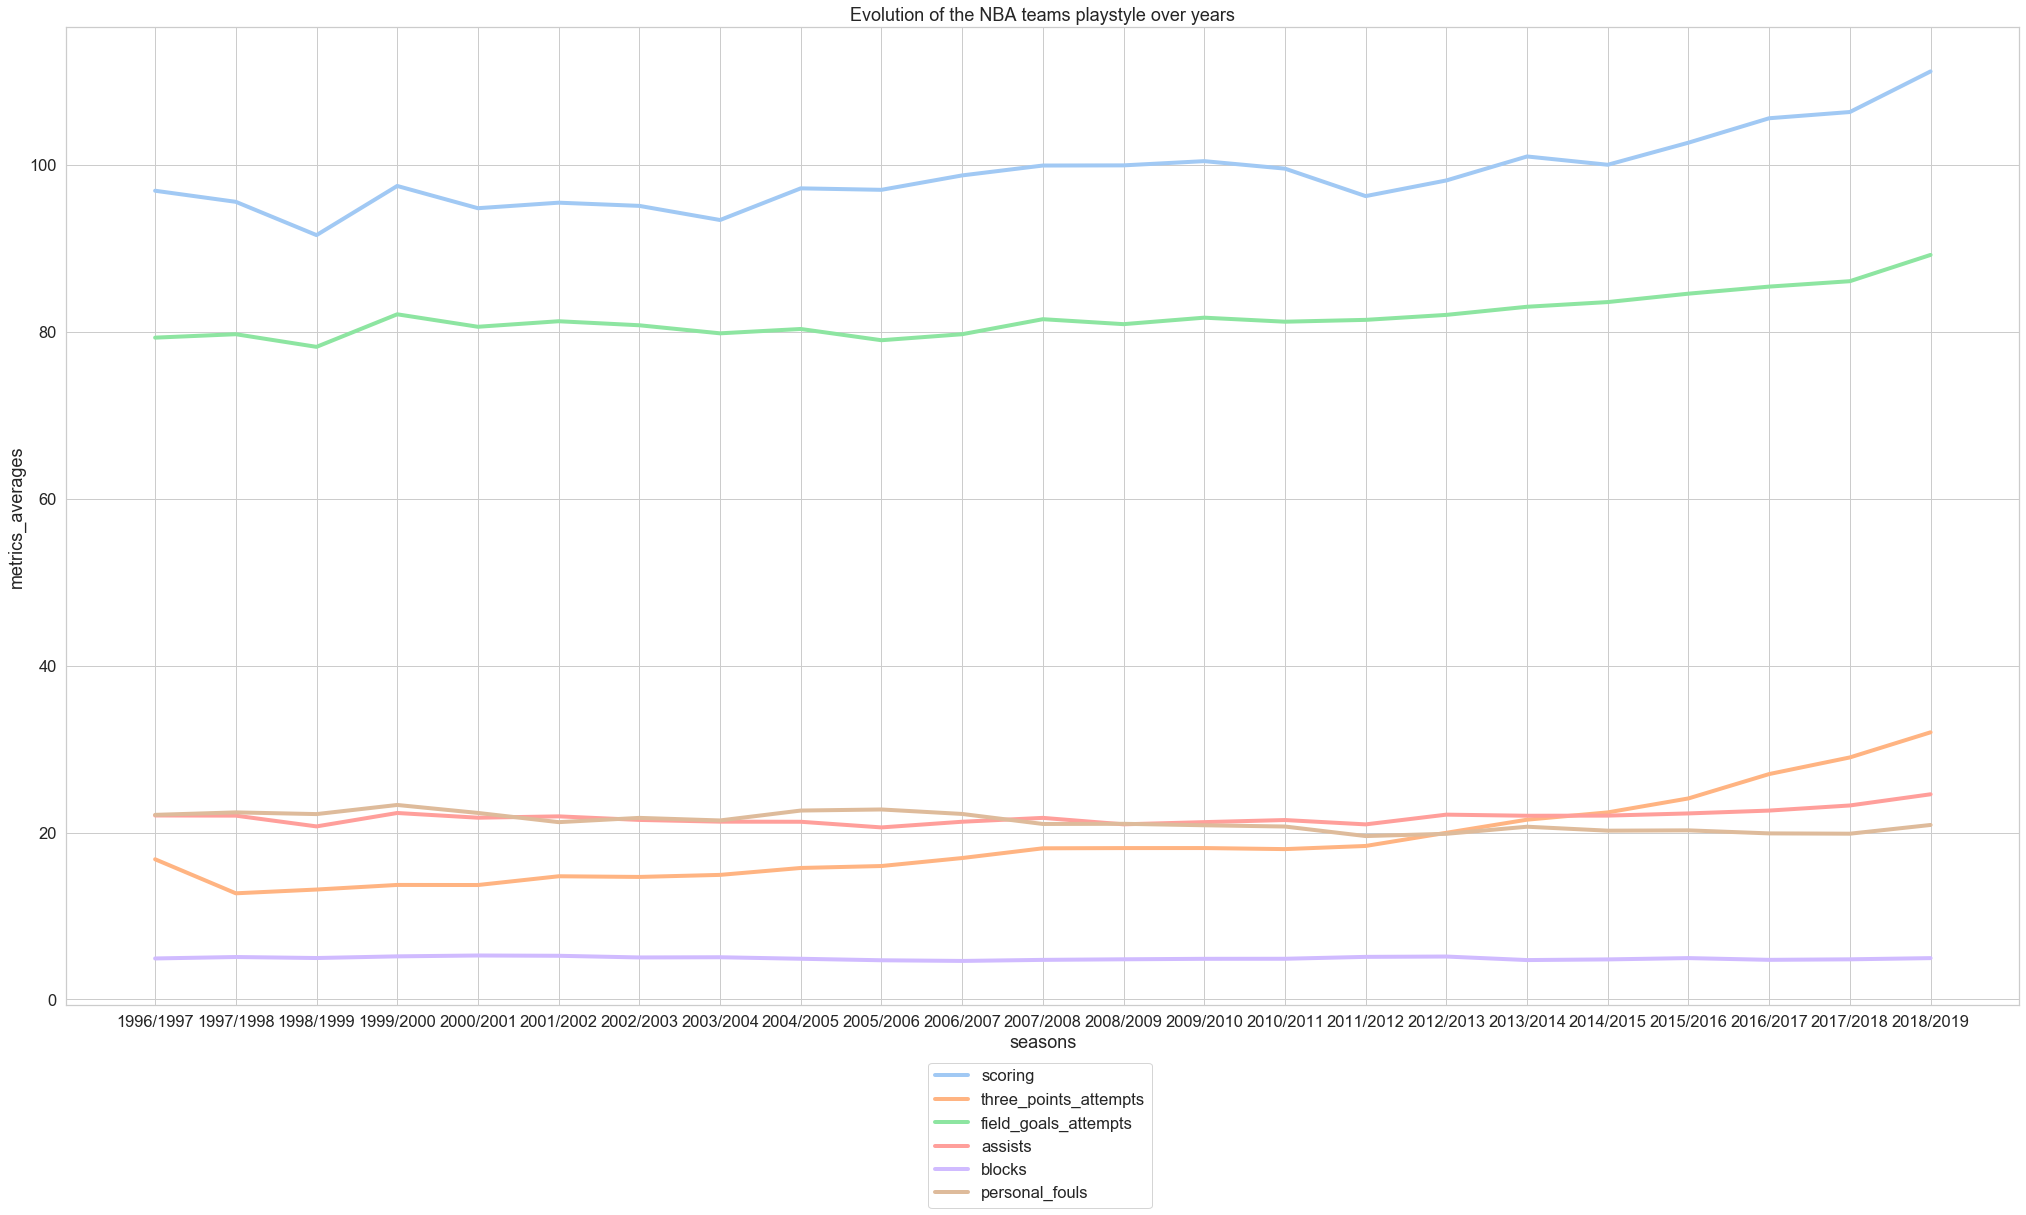

In [15]:
### Checking the evolution of some offensive metrics over years

metrics_to_compare = [
    'season', 'scoring_average', 'three_points_attempts',
    'field_goals_attempts', 'assists', 'blocks',
    'personal_fouls'
]

metrics_legends = [
    'scoring', 'three_points_attempts', 'field_goals_attempts',
    'assists', 'blocks', 'personal_fouls'
]

df_metrics_years = df[metrics_to_compare].groupby('season').mean()

plt.figure(figsize=(35, 18))
plt.plot(df_metrics_years['scoring_average'], linewidth=4)
plt.plot(df_metrics_years['three_points_attempts'], linewidth=4)
plt.plot(df_metrics_years['field_goals_attempts'], linewidth=4)
plt.plot(df_metrics_years['assists'], linewidth=4)
plt.plot(df_metrics_years['blocks'], linewidth=4)
plt.plot(df_metrics_years['personal_fouls'], linewidth=4)
plt.xlabel('seasons')
plt.ylabel('metrics_averages')
plt.legend(metrics_legends, bbox_to_anchor=(0.56, -0.05))
plt.title('Evolution of the NBA teams playstyle over years')

**Insights from the plot above :**
-  The scoring has gradually increased over seasons.
-  The field goals attempts also increased over seasons.
-  The three points attemps also increased over seasons.

> **Key takeaway** : the three metrics above has increased over time due to the fact that in the current NBA, teams are playing at a higher pace (number of possessions played per game) which consequently leads to more shoot attempts (three pointers + two pointers = field goals) and thus to more scoring opportunities.

We can also notice that the assists, blocks haven't really changed over seasons but the number of personal fouls has decreased over time, which shows that teams today are more focused on offense and less on defense, which is also one of the consequences on the scoring increase over years.

Text(0.5, 1.0, 'Previous teams that finished first the most in the regular season prior to the 2019/2020 season')

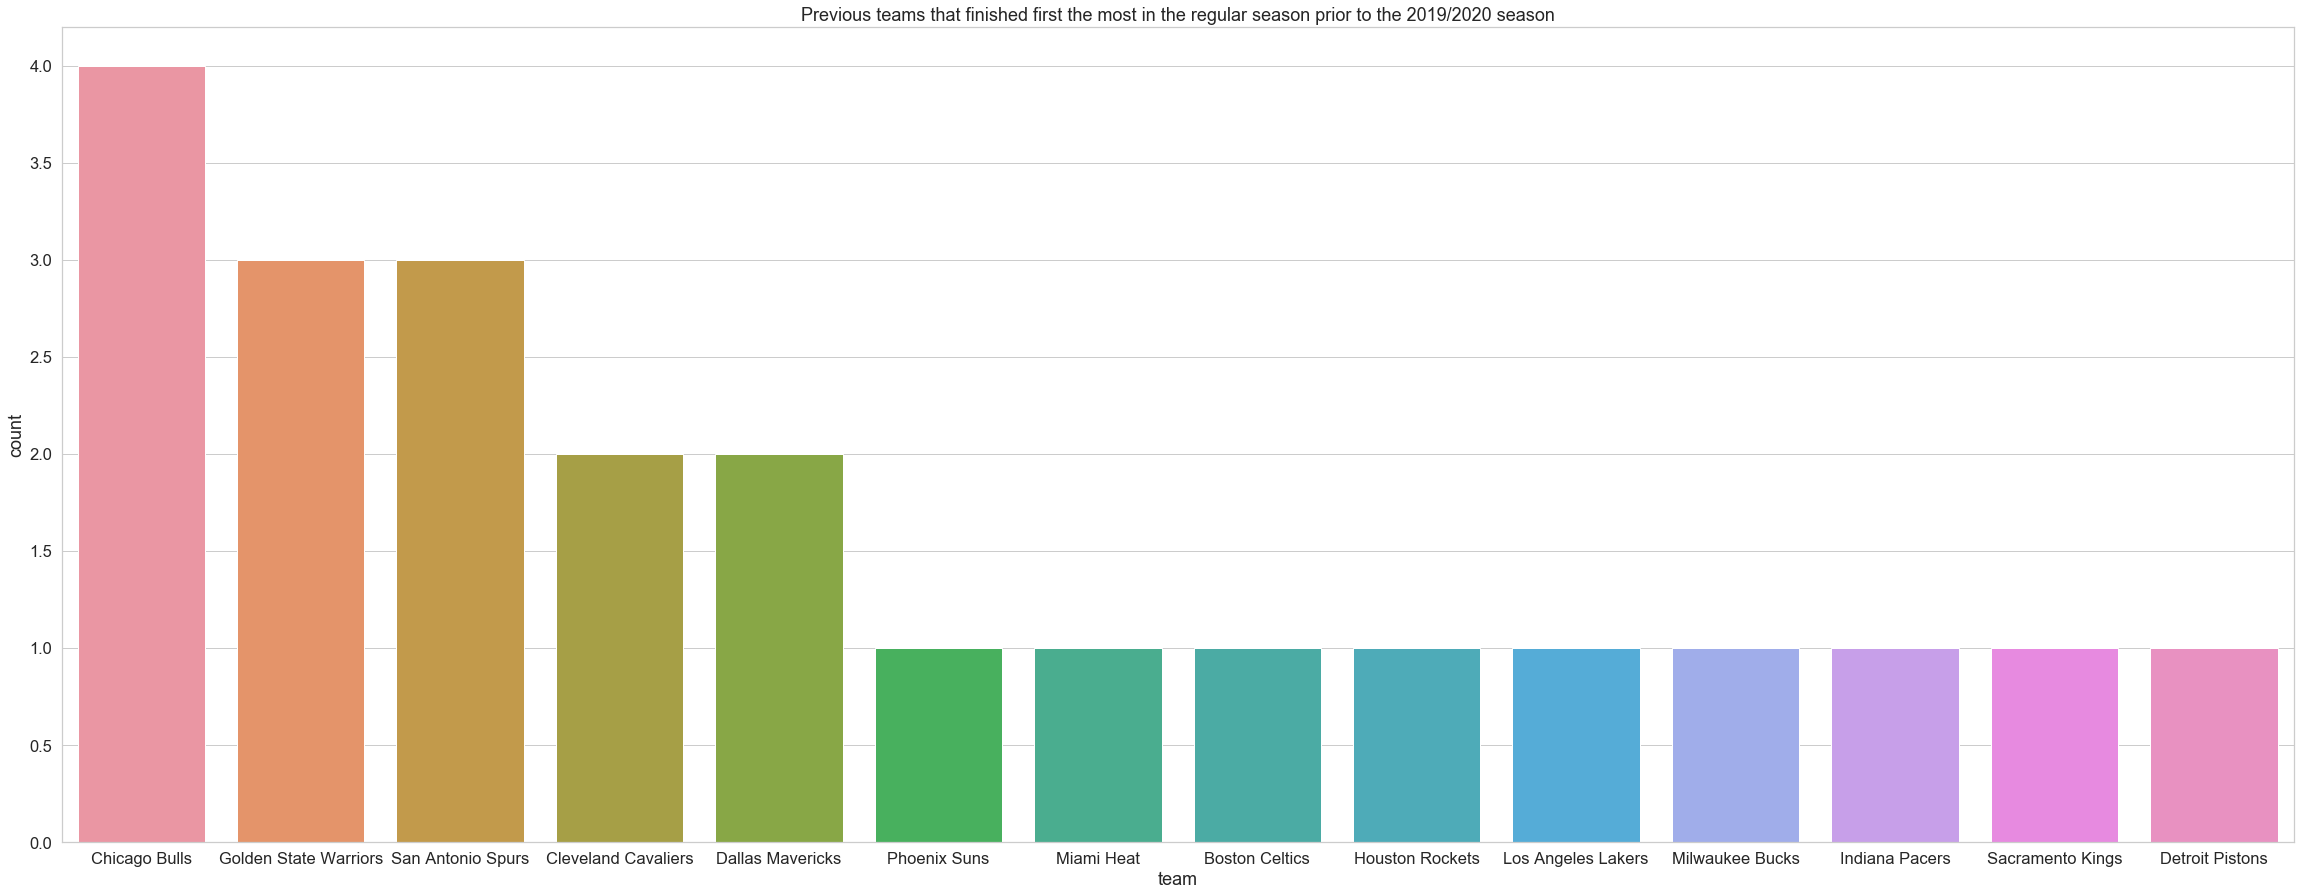

In [21]:
### Checking which teams were ranked first from previous seasons

df_first = df[df['regular_season_rank'] == 1]
plt.figure(figsize=(40, 15))
sns.countplot(x='team', data=df_first, order=df_first['team'].value_counts().index)
plt.title('Previous teams that finished first the most in the regular season prior to the 2019/2020 season')

**Insights from the plot above :**

From the plot above it seems that a team rarely finished first in the regular season ranking a lot (as shown by the teams diversity from 1996 to 2019), this could be explained by the fact that a regular season is very long (82 games) and as most of the teams just want to qualify for the playoffs (top 16), most of them sometimes voluntarily loss some games in order to let their best players to rest.

Text(0.5, 1.0, 'Teams that made the playoffs the most prior to the 2019/2020 season')

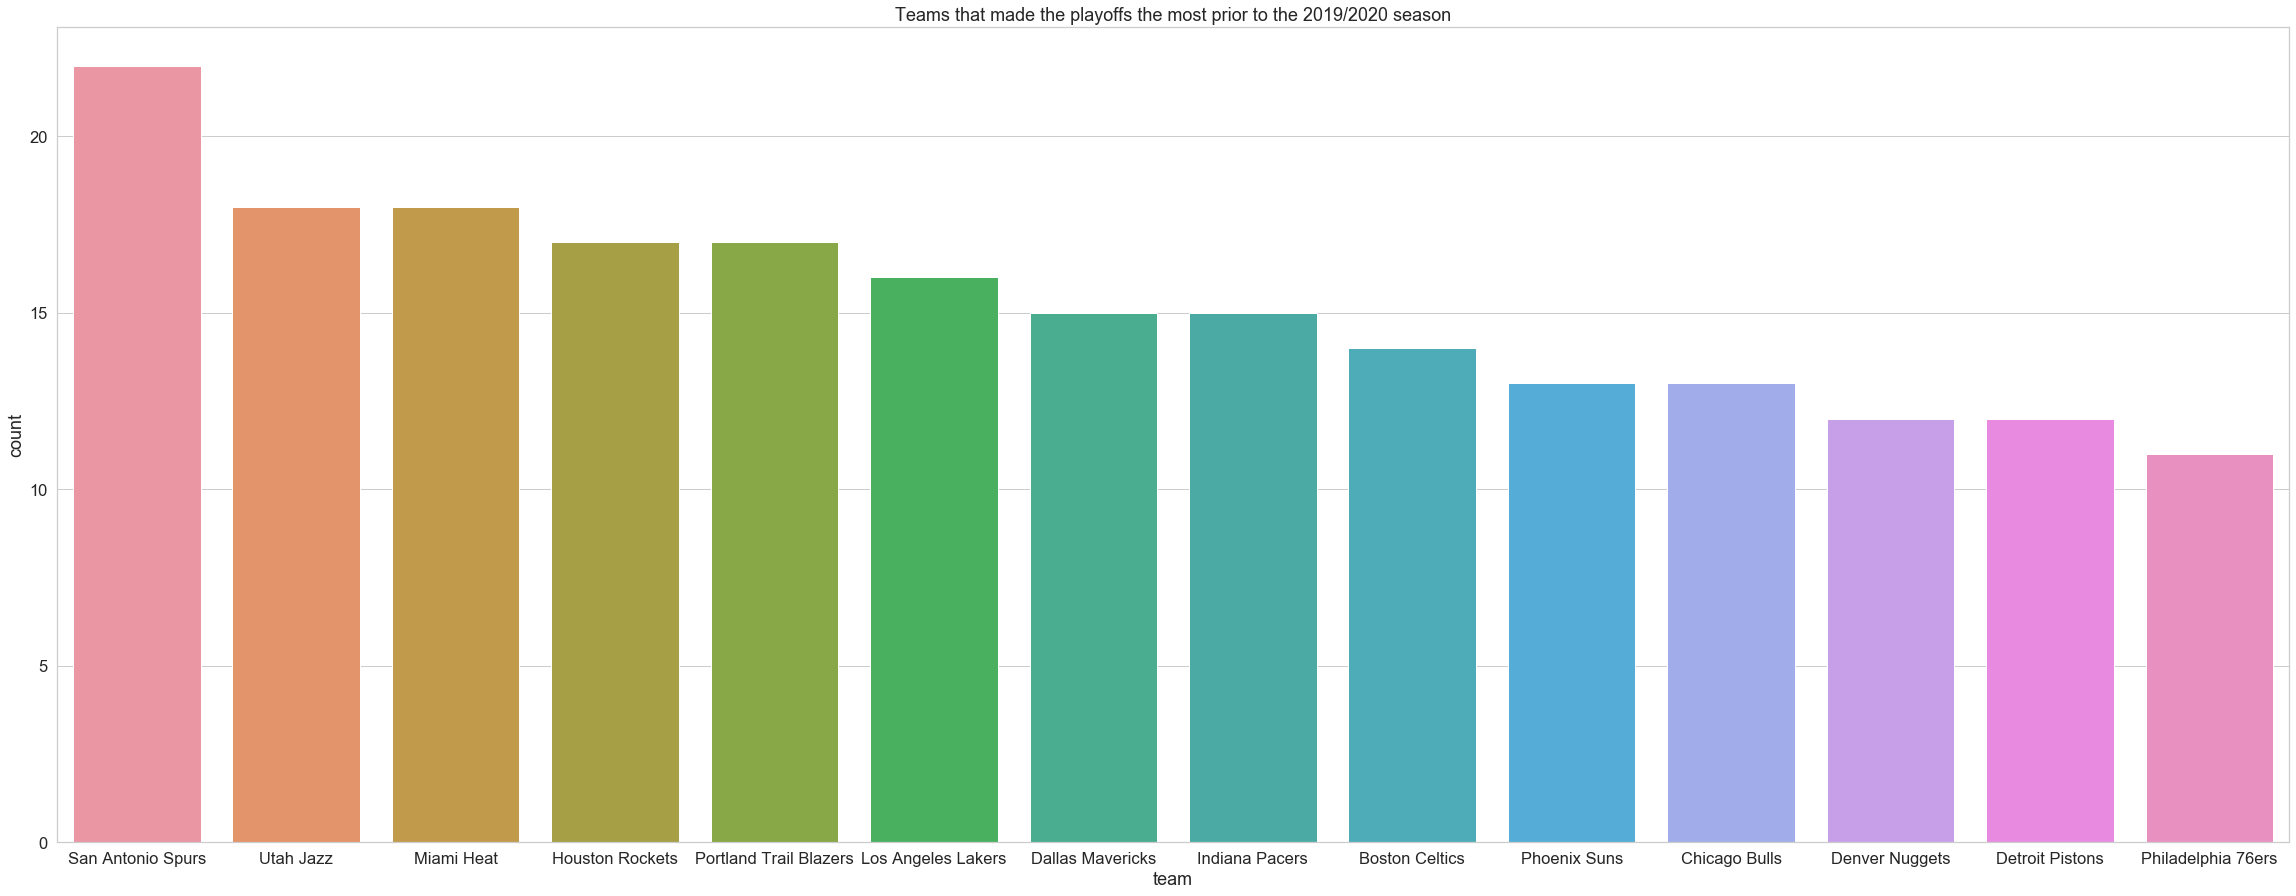

In [20]:
### Checking which teams went to the playoffs the most often

df_playoffs = df[df['regular_season_rank'] <= 16]
plt.figure(figsize=(40, 15))
sns.countplot(x='team', data=df_playoffs, order=df_playoffs['team'].value_counts().index[:14])
plt.title('Teams that made the playoffs the most prior to the 2019/2020 season')

**Insights from the plot above :**

The plot above shows that even if a team made the playoffs a lot time, it doesn't necessarly mean that he will be able to go to the playoffs after the current regular season (the only exception being the San Antonio Spurs who managed to qualify for the playoffs from 1998 to 2019 consecutively).

Indeed, for example, the teams below won't probably make the playoffs :
-  Chicago Bulls (they were good from 1996-1998 then 2008-2015 - thanks Michael Jordan, Scottie Pippen and Derrick Rose).
-  Phoenix Suns (they were good before 2011 - thanks Steve Nash, Amar'e Stoudemire and Mike D'Antoni).

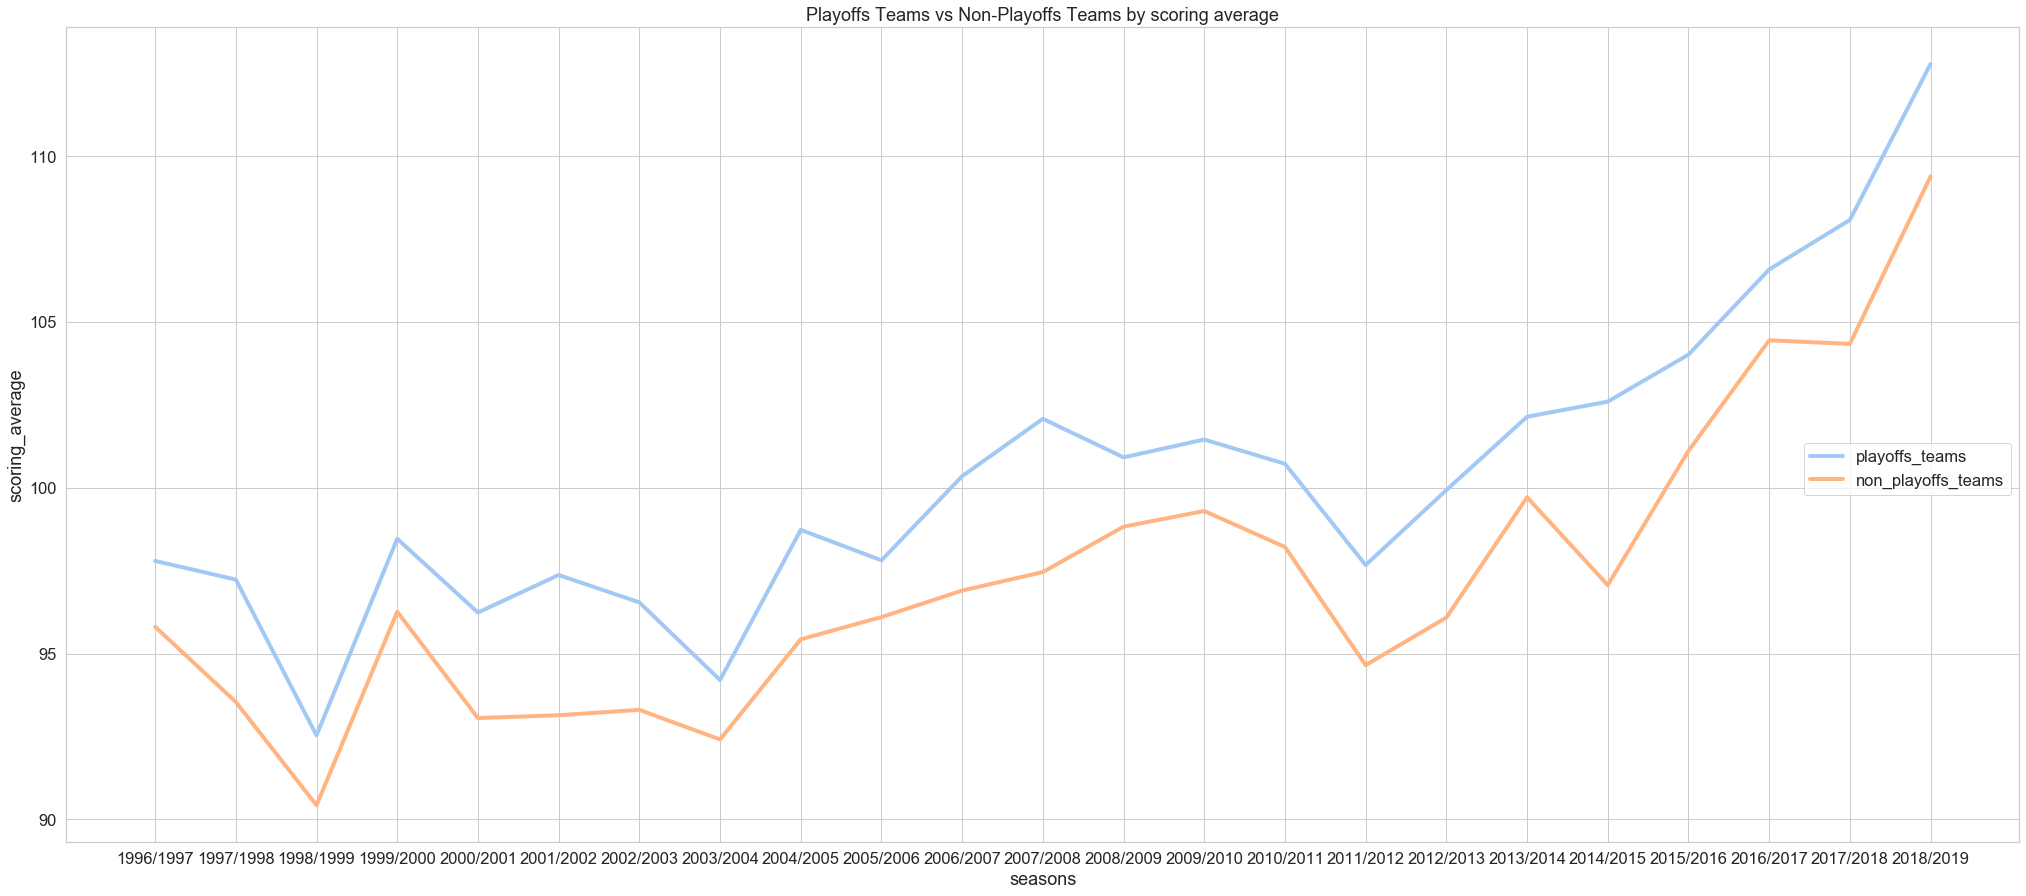

In [22]:
### Comparing the scoring average of the playoffs teams with non-playoffs teams

scoring_features = [
    'scoring_average', 'season'
]

legend_features = [
    'playoffs_teams', 'non_playoffs_teams'
]

df_playoffs = df[df['regular_season_rank'] <= 16][scoring_features].groupby(['season']).mean()
df_no_playoffs = df[df['regular_season_rank'] > 16][scoring_features].groupby(['season']).mean()

plt.figure(figsize=(35, 15))
plt.plot(df_playoffs['scoring_average'], linewidth=4)
plt.plot(df_no_playoffs['scoring_average'], linewidth=4)
plt.xlabel('seasons')
plt.ylabel('scoring_average')
plt.legend(legend_features, bbox_to_anchor=(1, 0.5))
plt.title('Playoffs Teams vs Non-Playoffs Teams by scoring average')
plt.show()

**Insights from the plot above :**

-  The plot above shows that the playoffs teams are way better than the non-playoffs teams from an offense perspective (almost 9% of difference in terms of scoring average between the two groups).
-  This graph also highlights the explosion in terms of points scored over the seasons (+22% from 1996 to 2019), which once again shows that teams today, during the regular season at least, essentially focus themselves on offense and less on defense (scoring 118 points per match was a very hard task to do in the 90' as shown by this graph, where every single player was playing very physically).

> **Key takeaway :** So we can conclude that to be able to reach the playoffs (top 16), a team should at least have a great offensive power (after all, scoring baskets is the main purpose of Basket-Ball right ?).

Text(0.5, 1.0, 'Teams that won the NBA title the most between 1996 and 2019')

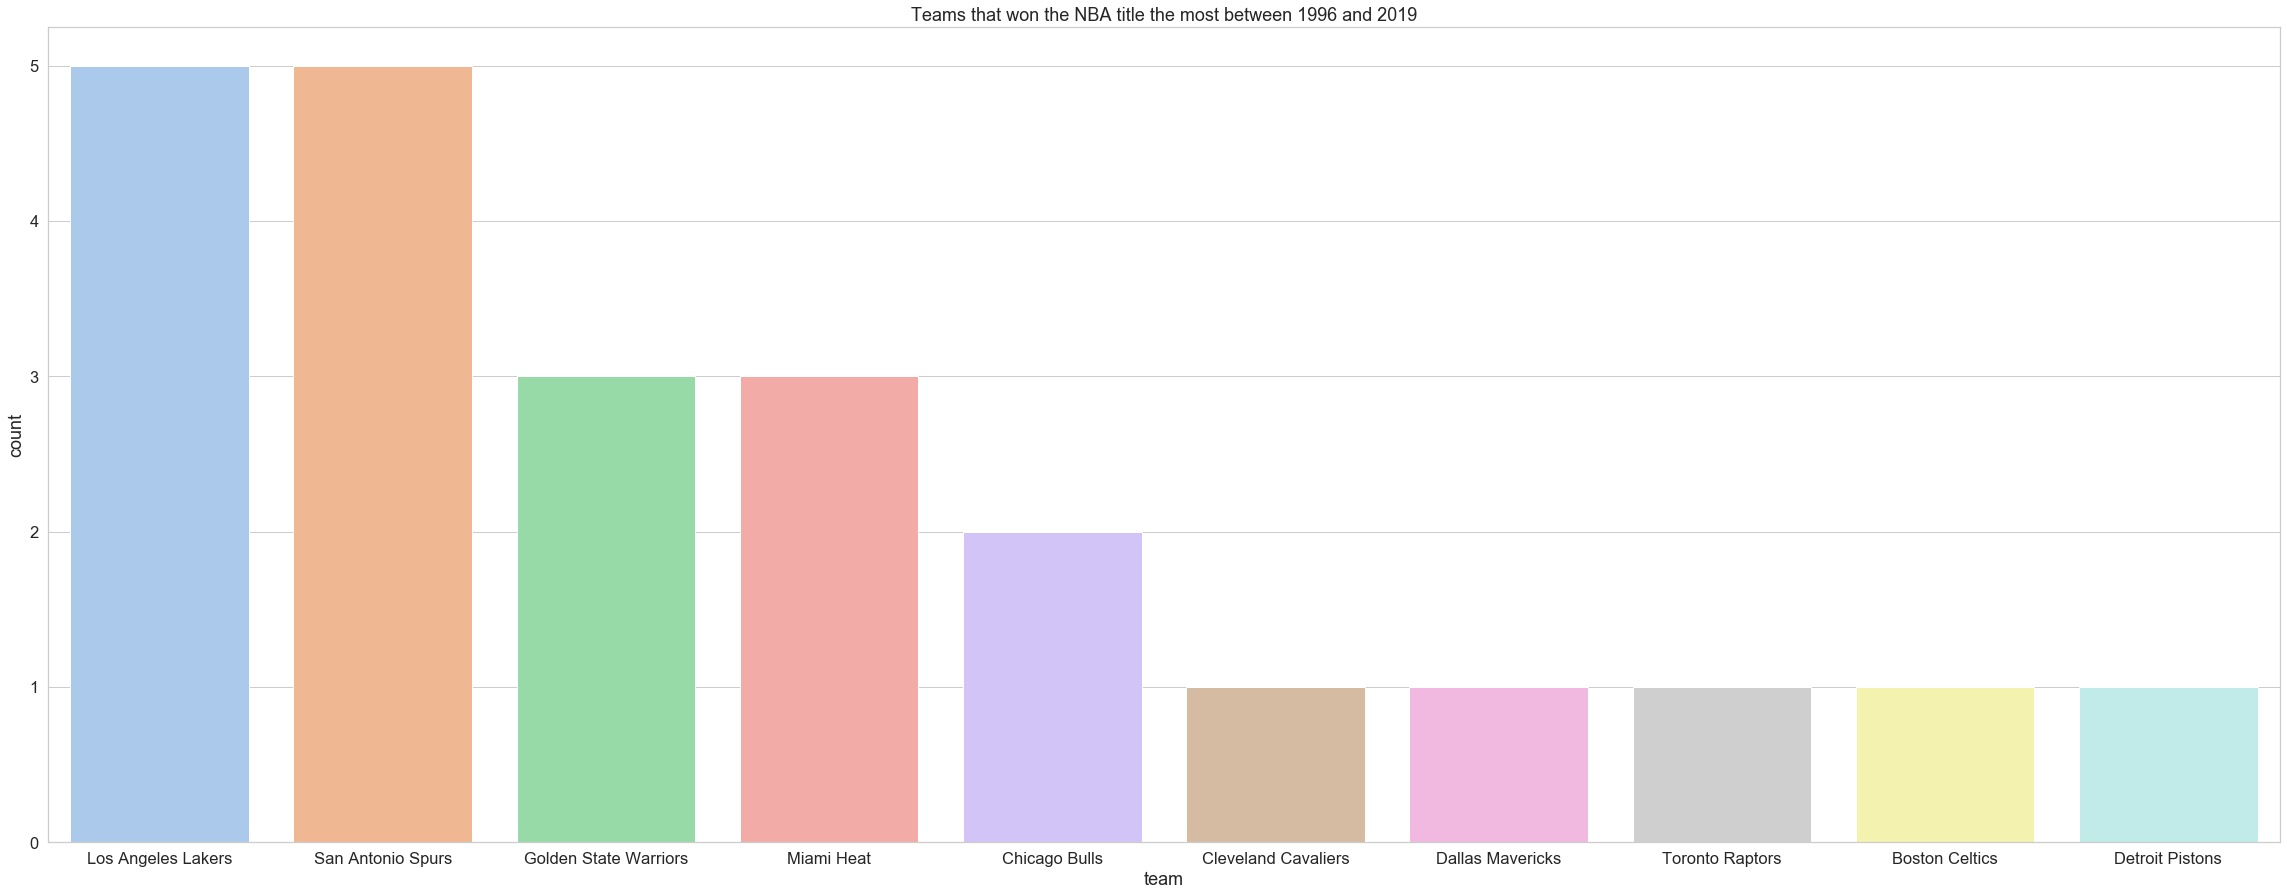

In [50]:
### Checking which teams won the NBA title the most between 1996 and 2019

df_winners = df[df['title_win'] == 1]

plt.figure(figsize=(40, 15))
sns.countplot(x='team', data=df_winners, order=df_winners['team'].value_counts().index[:10])
plt.title("Teams that won the NBA title the most between 1996 and 2019")

**Insights from the plot above :**

It looks the Los Angeles Lakers, San Antonio Spurs, Golden State Warriors, Miami Heat and the Chicago Bulls were the most dominant teams between 1996 and 2019, with each having its own period of domination :
-  Los Angeles Lakers (2000, 2001, 2002, 2009, 2010)
-  San Antonio Spurs (1999, 2003, 2005, 2007, 2014)
-  Golden State Warriors (2015, 2017, 2018)
-  Miami Heat (2006, 2012, 2013)
-  Chicago Bulls (1997, 1998)

Text(0.5, 1.0, 'Teams that won the NBA title the most between 1996 and 2019 - regular season rankings')

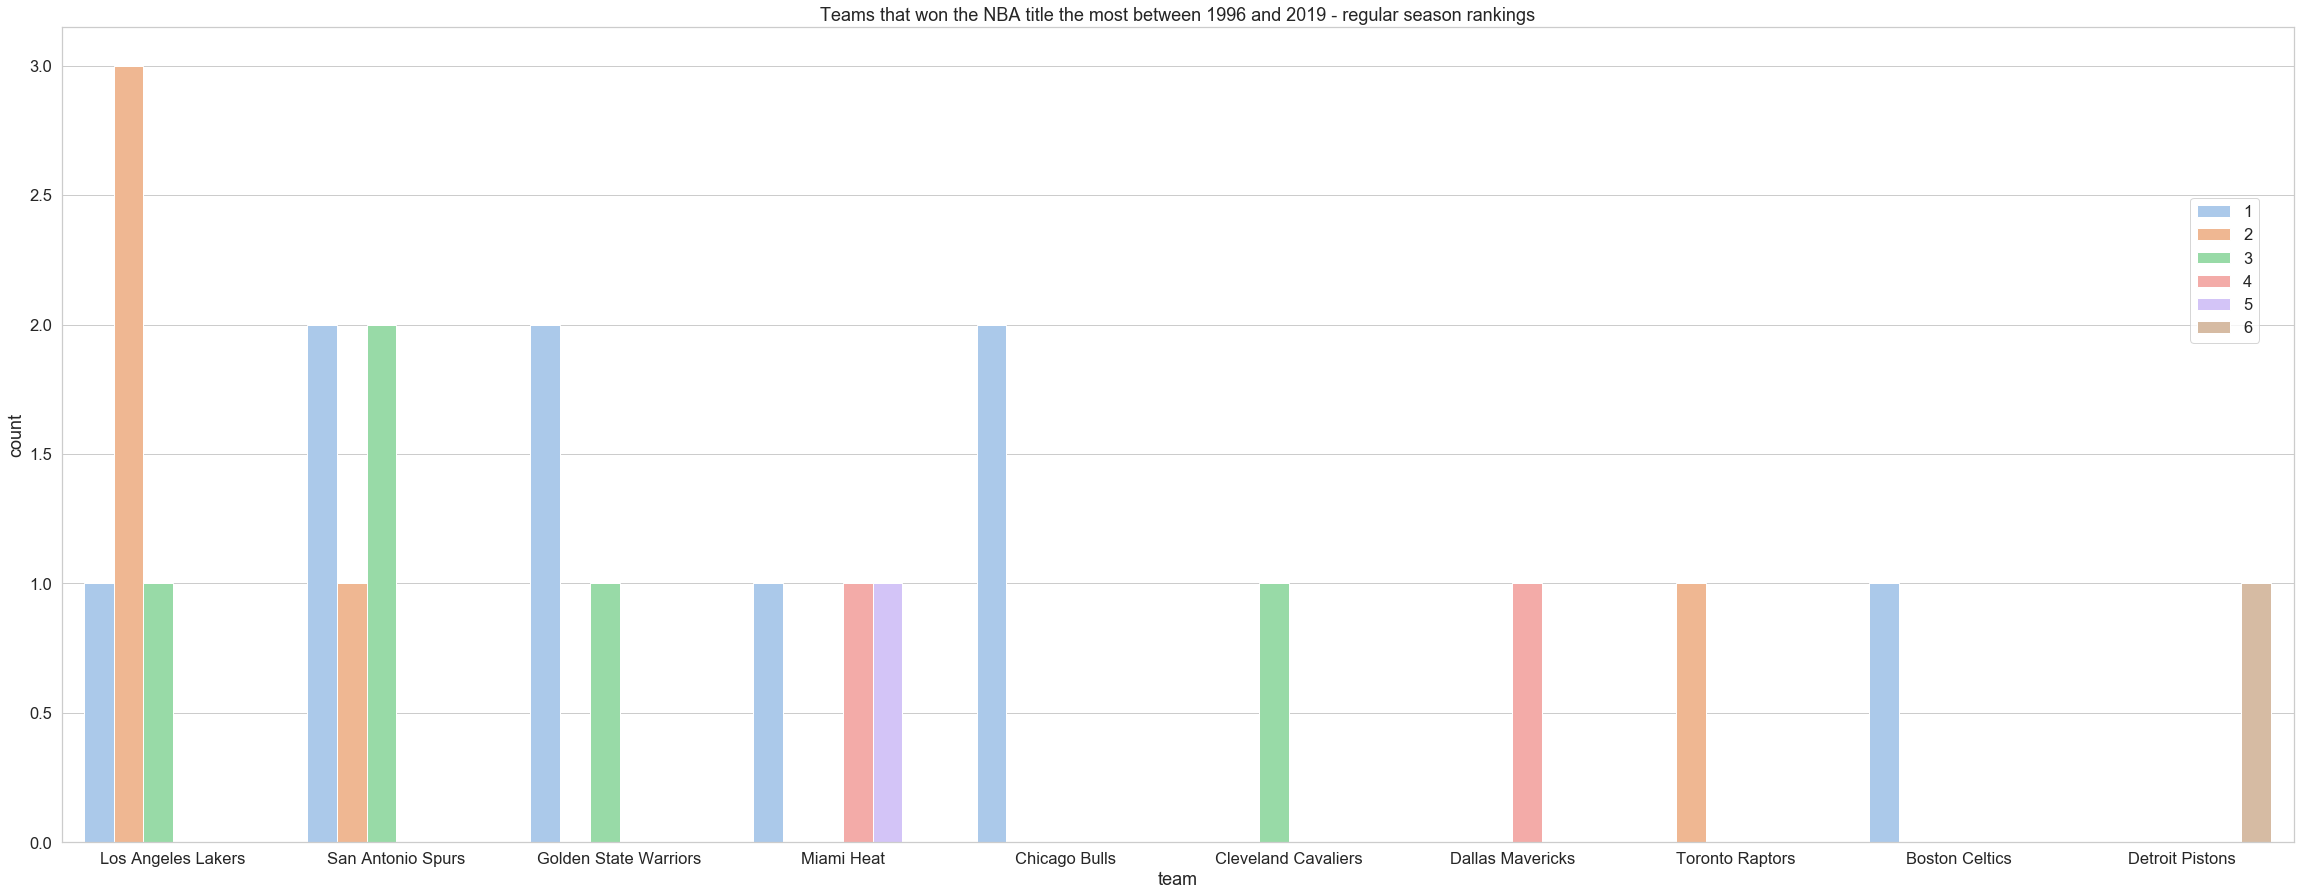

In [54]:
### Checking if a team needs to be ranked first during the regular season to be champion

plt.figure(figsize=(40, 15))
sns.countplot(x='team', data=df_winners, order=df_winners['team'].value_counts().index[:10], hue="regular_season_rank")
plt.legend(bbox_to_anchor=(0.95, 0.8))
plt.title("Teams that won the NBA title the most between 1996 and 2019 - regular season rankings")

**Insights from the plot above :**

It seems that most of the winners weren't necessarly ranked first during the regular season in order to be able to win the NBA title (c.f Cleveland Cavaliers, Dallas Mavericks, Toronto Raptors). This can be due to the fact that during the regular season, key players are often under load management (i.e they are voluntary declared as not able to play in order for them to rest themselves) in order to be in a better form once the playoffs start.

Nevertheless, most of the teams often managed to secure the best ranking possible during the regular season in order to have the homecourt advantage over the other teams, which is a considerable advantage actually.

>**Key takeway** : A team doesn't necessarly have to be ranked first in the regular season to be able to win the NBA title.

### 4. Feature Engineering

-  Categorical features encoding
-  Features selection

#### 4.1. Categorical features encoding

We will use One-Hot Encoding to encode the season and the team values as they aren't ordinal so we can't use LabelEncoding.

In [55]:
### Overview of the DataFrame

print(df.shape)
df.head()

(682, 30)


season                   team  title_win  regular_season_rank  \
0  2018/2019        Milwaukee Bucks          0                    1   
1  2018/2019        Toronto Raptors          1                    2   
2  2018/2019  Golden State Warriors          0                    3   
3  2018/2019         Denver Nuggets          0                    4   
4  2018/2019        Houston Rockets          0                    5   

   game_played  wins  losses  wins_ratio  minutes_played  scoring_average  \
0         82.0  60.0    22.0       0.732            48.2            118.1   
1         82.0  58.0    24.0       0.707            48.5            114.4   
2         82.0  57.0    25.0       0.695            48.3            117.7   
3         82.0  54.0    28.0       0.659            48.1            110.7   
4         82.0  53.0    29.0       0.646            48.4            113.9   

   ...  defensive_rebounds  total_rebounds  assists  turnovers  steals  \
0  ...                40.4            49.7     26.0       13.9     7.5   
1  ...                35.6            45.2     25.4       14.0     8.3   
2  ...                36.5            46.2     29.4       14.3     7.6   
3  ...                34.5            46.4     27.4       13.4     7.7   
4  ...                31.9            42.1     21.2       13.3     8.5   

   blocks  blocks_attempts  personal_fouls  personal_fouls_drawn  plus_minus  
0     5.9              4.8            19.6                  20.2         8.9  
1     5.3              4.5            21.0                  20.5         6.1  
2     6.4              3.6            21.4                  19.5         6.5  
3     4.4              5.0            20.0                  20.4         4.0  
4     4.9              4.5            22.0                  20.0         4.8  

[5 rows x 30 columns]

In [56]:
### Using One-Hot Encoding

def one_hot_encode(df, feature):
    '''
    Function that allows the user to apply One-Hot Encoding to features.
    
    Parameters:
        - df: the input DataFrame that contains the features to encode.
        - feature: the features to encode.
    '''
    
    dummy = pd.get_dummies(df[feature], prefix = feature, drop_first = False)
    df = pd.concat([df, dummy], axis = 1)
    
    df = df.drop(feature, axis = 1)
    df = df.dropna() 
    
    return df

feat_to_encode = [
    'season', 'team'
]

df_encoded = one_hot_encode(df, feat_to_encode)
print(df_encoded.shape)
df_encoded.head()

(682, 89)


title_win  regular_season_rank  game_played  wins  losses  wins_ratio  \
0          0                    1         82.0  60.0    22.0       0.732   
1          1                    2         82.0  58.0    24.0       0.707   
2          0                    3         82.0  57.0    25.0       0.695   
3          0                    4         82.0  54.0    28.0       0.659   
4          0                    5         82.0  53.0    29.0       0.646   

   minutes_played  scoring_average  field_goals_made  field_goals_attempts  \
0            48.2            118.1              43.4                  91.1   
1            48.5            114.4              42.2                  89.1   
2            48.3            117.7              44.0                  89.8   
3            48.1            110.7              41.9                  90.0   
4            48.4            113.9              39.2                  87.4   

   ...  team_Phoenix Suns  team_Portland Trail Blazers  team_Sacramento Kings  \
0  ...                  0                            0                      0   
1  ...                  0                            0                      0   
2  ...                  0                            0                      0   
3  ...                  0                            0                      0   
4  ...                  0                            0                      0   

   team_San Antonio Spurs  team_Seattle SuperSonics  team_Toronto Raptors  \
0                       0                         0                     0   
1                       0                         0                     1   
2                       0                         0                     0   
3                       0                         0                     0   
4                       0                         0                     0   

   team_Utah Jazz  team_Vancouver Grizzlies  team_Washington Bullets  \
0               0                         0                        0   
1               0                         0                        0   
2               0                         0                        0   
3               0                         0                        0   
4               0                         0                        0   

   team_Washington Wizards  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 89 columns]

#### 4.2. Features Selection

As the One-Hot Encoding generated a lot of new features (+59), we absolutely need to remove some features from the dataset in order to save computation time and to remove noises in the data.

We have noticed in the Exploratory Data Analysis that there were a lot of features that were correlated between them, so this will enable us to remove some of them because feeding the models with the same data is equivalent to feeding him with noises, which is counter-productive and can reduce its predictive power.

In [22]:
### Checking the features inside of the DataFrame

df_encoded.columns

Index(['rank', 'game_played', 'wins', 'losses', 'wins_ratio', 'minutes_played',
       'scoring_average', 'field_goals_made', 'field_goals_attempts',
       'field_goals_percentage', 'three_points_made', 'three_points_attempts',
       'three_points_percentage', 'free_throws_made', 'free_throws_attempts',
       'free_throws_percentage', 'offensive_rebounds', 'defensive_rebounds',
       'total_rebounds', 'assists', 'turnovers', 'steals', 'blocks',
       'blocks_attempts', 'personal_fouls', 'personal_fouls_drawn',
       'plus_minus', 'season_1996/1997', 'season_1997/1998',
       'season_1998/1999', 'season_1999/2000', 'season_2000/2001',
       'season_2001/2002', 'season_2002/2003', 'season_2003/2004',
       'season_2004/2005', 'season_2005/2006', 'season_2006/2007',
       'season_2007/2008', 'season_2008/2009', 'season_2009/2010',
       'season_2010/2011', 'season_2011/2012', 'season_2012/2013',
       'season_2013/2014', 'season_2014/2015', 'season_2015/2016',
       'season_2

In [38]:
### Checking which features are correlated to the target variable - rank (at least 20% of correlation)

correlations = df_encoded.drop(['rank'], axis = 1).apply(lambda x: x.corr(df_encoded['rank']))
relevant_features = correlations[(correlations > 0.2) | (correlations < -0.2)]
relevant_features

wins                      -0.934155
losses                     0.937152
wins_ratio                -0.976867
scoring_average           -0.316664
field_goals_made          -0.255555
field_goals_percentage    -0.554127
three_points_percentage   -0.418805
defensive_rebounds        -0.320505
total_rebounds            -0.235905
assists                   -0.357539
turnovers                  0.320511
blocks                    -0.239330
blocks_attempts            0.442958
personal_fouls             0.213376
plus_minus                -0.946405
team_San Antonio Spurs    -0.214970
dtype: float64

In [59]:
### Removing all the features that have less that have a correlations interval between [-0.22; 0.22]

features_to_keep = [
    'wins', 'losses', 'wins_ratio',
    'scoring_average', 'field_goals_made', 'field_goals_percentage',
    'three_points_percentage', 'defensive_rebounds', 'total_rebounds',
    'assists', 'turnovers', 'blocks',
    'blocks_attempts', 'personal_fouls', 'plus_minus',
    'rank'
]

df_filtered = df_encoded[features_to_keep]
print(df_filtered.shape)
df_filtered.head()

(682, 16)


wins  losses  wins_ratio  scoring_average  field_goals_made  \
0  60.0    22.0       0.732            118.1              43.4   
1  58.0    24.0       0.707            114.4              42.2   
2  57.0    25.0       0.695            117.7              44.0   
3  54.0    28.0       0.659            110.7              41.9   
4  53.0    29.0       0.646            113.9              39.2   

   field_goals_percentage  three_points_percentage  defensive_rebounds  \
0                    47.6                     35.3                40.4   
1                    47.4                     36.6                35.6   
2                    49.1                     38.5                36.5   
3                    46.6                     35.1                34.5   
4                    44.9                     35.6                31.9   

   total_rebounds  assists  turnovers  blocks  blocks_attempts  \
0            49.7     26.0       13.9     5.9              4.8   
1            45.2     25.4       14.0     5.3              4.5   
2            46.2     29.4       14.3     6.4              3.6   
3            46.4     27.4       13.4     4.4              5.0   
4            42.1     21.2       13.3     4.9              4.5   

   personal_fouls  plus_minus  rank  
0            19.6         8.9     1  
1            21.0         6.1     2  
2            21.4         6.5     3  
3            20.0         4.0     4  
4            22.0         4.8     5

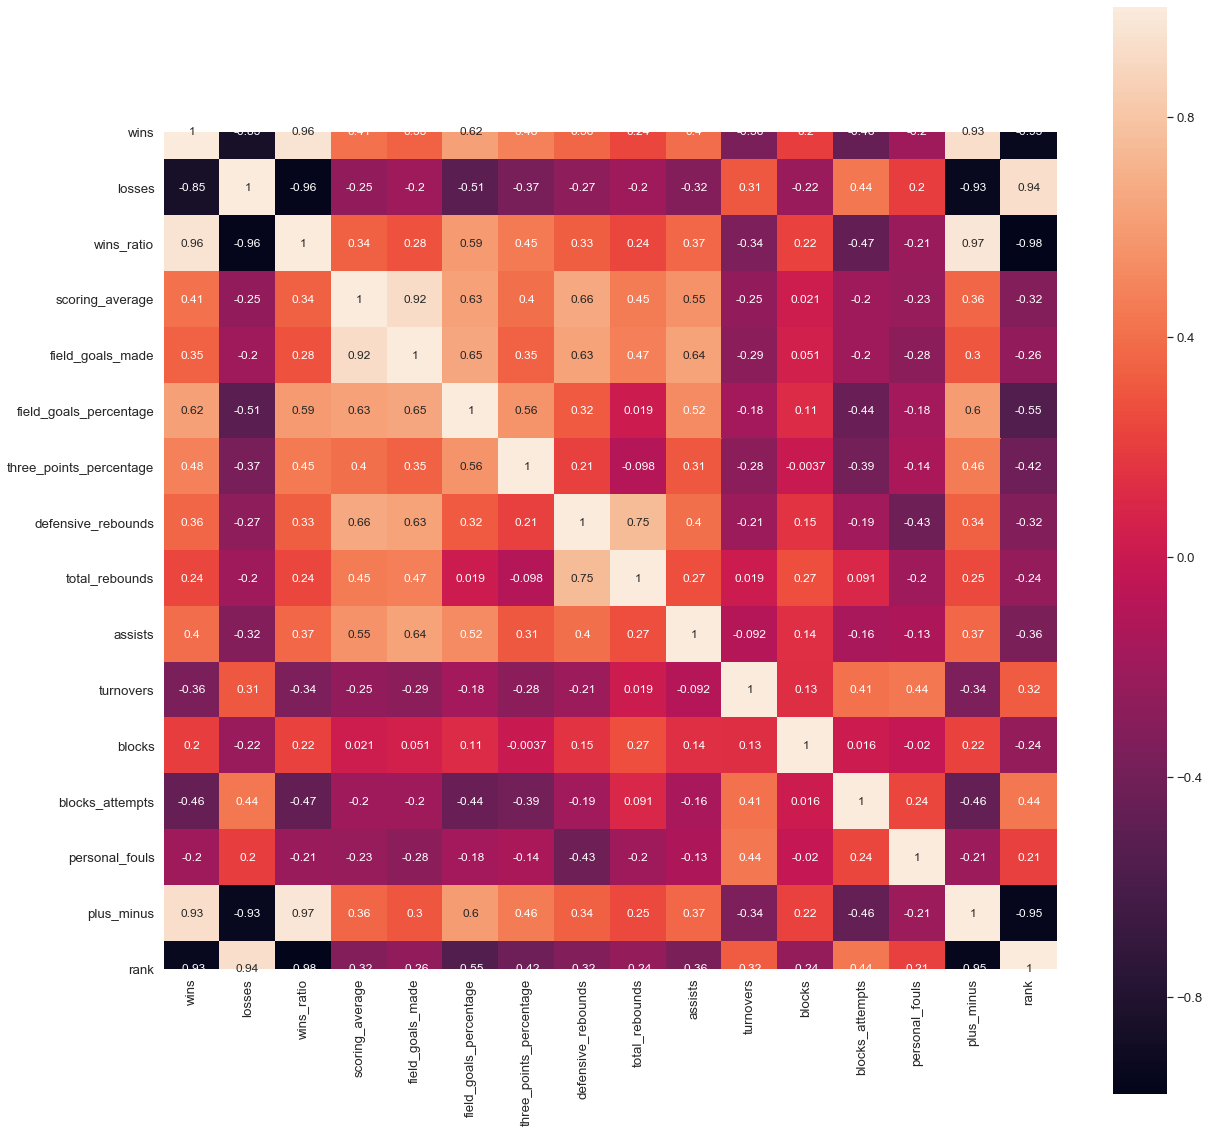

In [60]:
### Plotting a heatmap to see the last kept features are correlated between them

fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale = 1.2)
sns.heatmap(df_filtered.corr(), vmax=1, square=True, annot=True, annot_kws={"size":12}, ax=ax)

In [61]:
### Removing some extra features that are correlated between them

corr_feat_to_remove = [
    'wins', 'losses', 'field_goals_made',
    'defensive_rebounds'
]

df_final = df_filtered.drop(corr_feat_to_remove, axis=1)
print(df_final.shape)
df_final.head()

(682, 12)


wins_ratio  scoring_average  field_goals_percentage  \
0       0.732            118.1                    47.6   
1       0.707            114.4                    47.4   
2       0.695            117.7                    49.1   
3       0.659            110.7                    46.6   
4       0.646            113.9                    44.9   

   three_points_percentage  total_rebounds  assists  turnovers  blocks  \
0                     35.3            49.7     26.0       13.9     5.9   
1                     36.6            45.2     25.4       14.0     5.3   
2                     38.5            46.2     29.4       14.3     6.4   
3                     35.1            46.4     27.4       13.4     4.4   
4                     35.6            42.1     21.2       13.3     4.9   

   blocks_attempts  personal_fouls  plus_minus  rank  
0              4.8            19.6         8.9     1  
1              4.5            21.0         6.1     2  
2              3.6            21.4         6.5     3  
3              5.0            20.0         4.0     4  
4              4.5            22.0         4.8     5

After features selection, we now only have features that will have some sort of predictive power on our target variable (the rank) and they seem to be pretty coherent !

### 5. Data Preprocessing

-  Splitting the data in a training and test set
-  Scaling the data

#### 5.1. Splitting the data

We will split the dataset and allocate 80% of it to the training set and 20% of it to the testing set.

In [62]:
### Seperating the features and the target variable to two different DataFrames

X = df_final.drop('rank', axis=1)
y = df_final['rank']

print(X.shape)
print(y.shape)

(682, 11)
(682,)


In [131]:
### Creating the training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(545, 11)
(137, 11)
(545,)
(137,)


In [132]:
### Transferring the index to a column in order to be able to know to which team correspond the predicted value

X_train['index'] = X_train.index
X_test['index'] = X_test.index

In [133]:
### Looking at the target global distribution before the split

print('Target distribution : {}'.format(y.value_counts()))

### Looking at the target distribution for both training and test set

print('Target distribution for training set : {}'.format(y_train.value_counts()))
print('Target distribution for test set : {}'.format(y_test.value_counts()))

Target distribution : 15    23
29    23
2     23
3     23
4     23
5     23
6     23
7     23
8     23
9     23
10    23
11    23
12    23
13    23
14    23
1     23
16    23
17    23
18    23
19    23
20    23
21    23
22    23
23    23
24    23
25    23
26    23
27    23
28    23
30    15
Name: rank, dtype: int64
Target distribution for training set : 1     23
14    22
25    21
12    21
29    21
19    20
10    20
11    20
20    20
8     19
17    19
15    19
23    19
27    19
24    18
26    18
28    18
6     18
18    17
3     17
16    17
22    17
13    17
21    17
7     17
9     16
5     16
2     15
4     14
30    10
Name: rank, dtype: int64
Target distribution for test set : 4     9
2     8
5     7
9     7
21    6
3     6
7     6
13    6
18    6
16    6
22    6
30    5
24    5
28    5
26    5
6     5
17    4
15    4
27    4
23    4
8     4
20    3
10    3
19    3
11    3
25    2
12    2
29    2
14    1
Name: rank, dtype: int64


#### 5.2. Scaling the data

As most of the features in the dataframe follows a Normal Distribution, we can apply the StandardScaler to scale them.

In [134]:
### Training the scaler on training set in order to avoid data leakage

X_train_2 = X_train.drop('index', axis=1)
X_test_2 = X_test.drop('index', axis=1)

scaler = StandardScaler()
X_train_2 = pd.DataFrame(scaler.fit_transform(X_train_2), columns=X_train_2.columns)
X_test_2 = pd.DataFrame(scaler.transform(X_test_2), columns=X_test_2.columns)